# Growth Mechanism with Details

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data, normalize_0_1, reset_tails, remove_linear_bg, denoise_fft, denoise_median
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

## 1. Visualize the spots from collected data

In [3]:
para_path = './datasets/BeamCurrentLinearityTest_gaussian_fit_parameter.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='bg')
ds_para.dataset_names

['DiffractedBeam_1microAmp',
 'DiffractedBeam_point2microAmps',
 'DiffractedBeam_point3microAmps',
 'DiffractedBeam_point4microAmps',
 'DiffractedBeam_point5microAmps',
 'DiffractedBeam_point6microAmps',
 'DiffractedBeam_point6microAmps_CORRECT',
 'DiffractedBeam_point7microAmps',
 'DiffractedBeam_point8microAmps',
 'DiffractedBeam_point9microAmps',
 'DirectBeam_1microAmp',
 'DirectBeam_point2microAmps',
 'DirectBeam_point3microAmps',
 'DirectBeam_point4microAmps',
 'DirectBeam_point5microAmps',
 'DirectBeam_point6microAmps',
 'DirectBeam_point7microAmps',
 'DirectBeam_point8microAmps',
 'DirectBeam_point9microAmps']

In [10]:
from matplotlib.cm import viridis
import pandas as pd
import seaborn as sns

current_dict = {'DirectBeam_point2microAmps': '0.2 Amps', 'DirectBeam_point3microAmps': '0.3 Amps', 'DirectBeam_point4microAmps': '0.4 Amps', 'DirectBeam_point5microAmps': '0.5 Amps', 
                'DirectBeam_point6microAmps': '0.6 Amps', 'DirectBeam_point7microAmps': '0.7 Amps', 'DirectBeam_point8microAmps': '0.8 Amps', 'DirectBeam_point9microAmps': '0.9 Amps', 
                'DirectBeam_1microAmp': '1 Amps'}

colors = [viridis(i) for i in np.linspace(0.1, 0.9, len(current_dict))]


In [13]:
data = []
for k, v in zip(current_dict.keys(), current_dict.values()):
    sample_x, sample_y = ds_para.load_curve(growth=k, spot='spot', metric='img_sum', x_start=0)
    denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=1000)
    sample_x, denoised_sample_y = denoise_median(sample_x, denoised_sample_y, kernel_size=101)

    mean = np.mean(denoised_sample_y)
    std = np.std(denoised_sample_y)
    sample_x = sample_x[denoised_sample_y > mean-3*std]
    denoised_sample_y = denoised_sample_y[denoised_sample_y > mean-3*std]
    sample_x = sample_x[denoised_sample_y < mean+3*std]
    denoised_sample_y = denoised_sample_y[denoised_sample_y < mean+3*std]

    df = pd.DataFrame({'Current': v, 'Time': sample_x, 'Intensity': denoised_sample_y})
    data.append(df)

data = pd.concat(data, ignore_index=True)
data.sample(10)

,Current,Time,Intensity
72973,0.5 Amps,7.073,252641.033880
154888,0.8 Amps,22.397,315722.066015
133042,0.8 Amps,0.551,318551.815472
62793,0.4 Amps,18.899,231906.021593
89120,0.6 Amps,1.433,283795.877603
83628,0.5 Amps,17.728,251813.232249
107067,0.6 Amps,19.380,281956.995460
68286,0.5 Amps,2.386,252566.249943
1985,0.2 Amps,2.009,166820.989792
92676,0.6 Amps,4.989,283172.642645


C:\Users\yig319\AppData\Local\Temp\ipykernel_5744\770048672.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_pos = np.mean(intensity[-3000:])


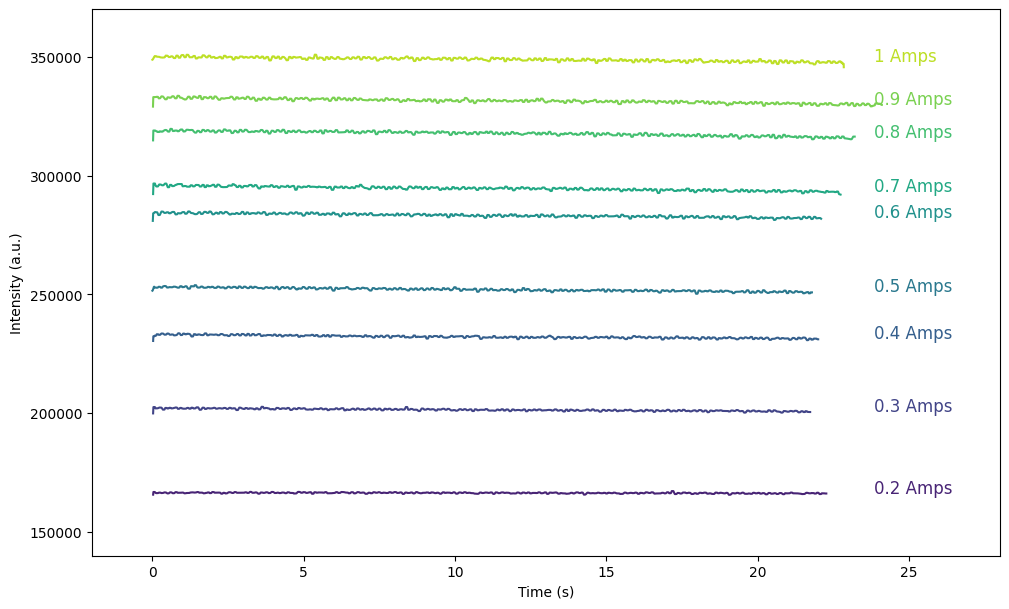

In [14]:
plt.subplots(1, 1, figsize=(10,6))
for i, v in enumerate(current_dict.values()):
    time = data[data['Current'] == v]['Time']
    intensity = data[data['Current'] == v]['Intensity']
    plt.plot(time, intensity, c=colors[i])
    y_pos = np.mean(intensity[-3000:]) 
    plt.text(sample_x[-1]+1, y_pos, v, fontsize=12, color=colors[i])
# plt.legend(g)
plt.xlim(-2, 28)
plt.ylim(1.4e5, 3.7e5)
plt.tight_layout()
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Time (s)')
plt.show()  

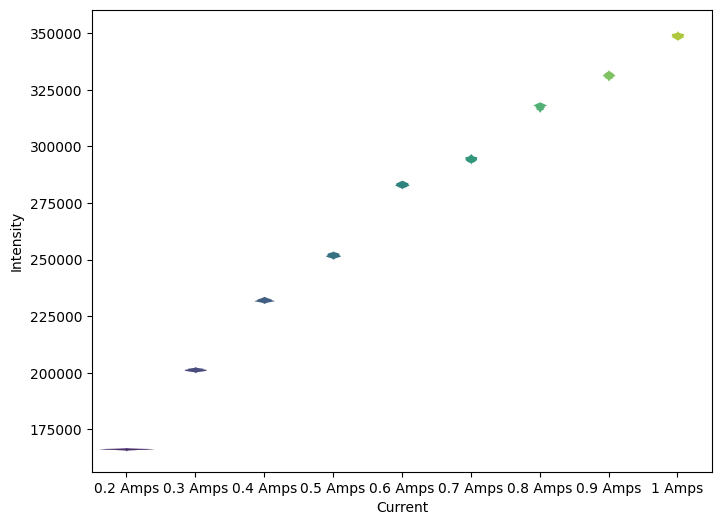

In [53]:
plt.subplots(1, 1, figsize=(8,6))
sns.violinplot(data=data, x='Current', y='Intensity', palette=colors, bw=.2, cut=1, linewidth=0)

plt.show()

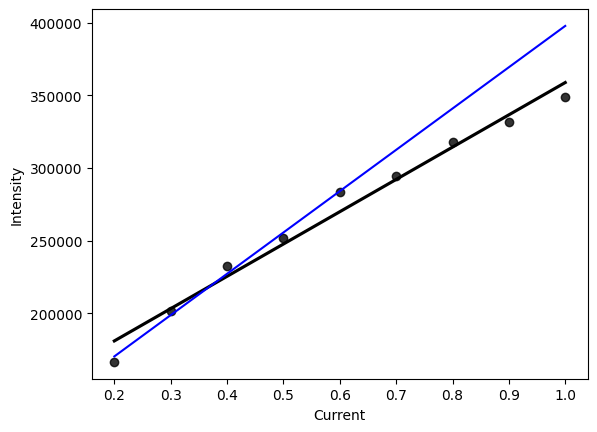

In [65]:
x, y = [], []
for i, v in enumerate(current_dict.values()):
    x.append(np.float32(v.split(' ')[0]))
    y.append(np.mean(data[data['Current'] == v]['Intensity']))
x, y = np.array(x), np.array(y)
slope, intercept = np.polyfit(x[:5], y[:5], 1)
fit_line = slope * x + intercept
fit_df = pd.DataFrame({'Current': x, 'Intensity': y, 'Fit Intensity': fit_line})
sns.regplot(data=fit_df, x='Current', y='Intensity', color='k', fit_reg=True, ci=None)
sns.lineplot(data=fit_df, x='Current', y='Fit Intensity', color='b')
plt.show()

In [ ]:
plt.subplots(1, 1, figsize=(10,6))
sns.violinplot(data=data, x='Current', y='Intensity', palette=colors, bw=.2, cut=1, linewidth=0)

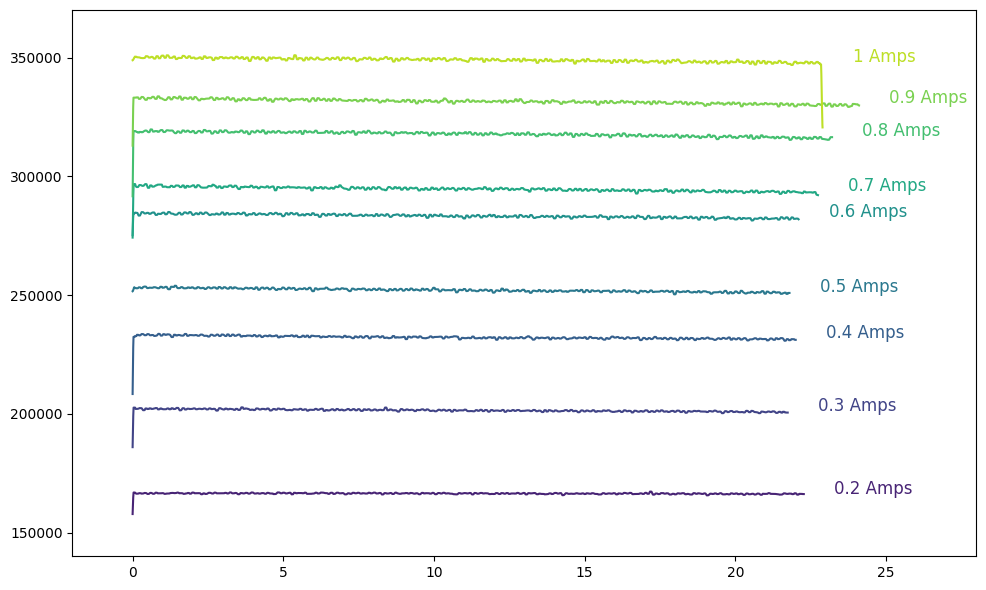

In [71]:
plt.subplots(1, 1, figsize=(10,6))
for i, g in enumerate(current_dict.keys()):

    sample_x, sample_y = ds_para.load_curve(growth=g, spot='spot', metric='img_sum', x_start=0)
    denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=1000)
    sample_x, denoised_sample_y = denoise_median(sample_x, denoised_sample_y, kernel_size=101)

    plt.plot(sample_x, denoised_sample_y, label=g, c=colors[i])
    y_pos = np.mean(denoised_sample_y[-10000:]) 
    plt.text(sample_x[-1]+1, y_pos, str(current_dict[g])+' Amps', fontsize=12, color=colors[i])

    mean = np.mean(denoised_sample_y)
    std = np.std(denoised_sample_y)
    denoised_sample_y = denoised_sample_y[denoised_sample_y > mean-3*std]
    denoised_sample_y = denoised_sample_y[denoised_sample_y < mean+3*std]
    mean_list.append(np.mean(denoised_sample_y))
    std_list.append(std)

# plt.legend(g)
plt.xlim(-2, 28)
plt.ylim(1.4e5, 3.7e5)
plt.tight_layout()
plt.show()  


<AxesSubplot: >

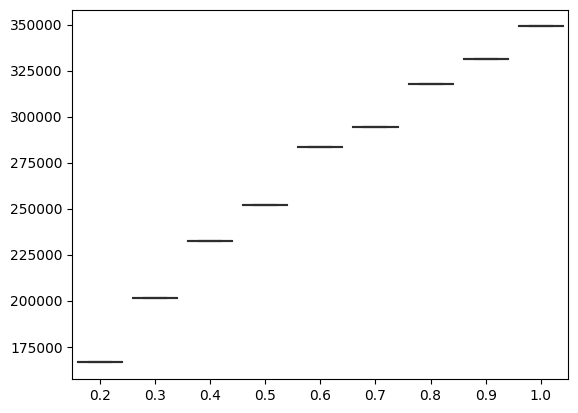

In [68]:
import seaborn as sns
current_list = list(current_dict.values())
sns.boxplot(x=current_list, y=mean_list, palette=colors)